In [2]:
#encoding: UTF-8

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

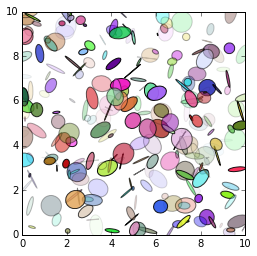

In [3]:
import matplotlib.pyplot as plt
import numpy.random as rnd
from matplotlib.patches import Ellipse

NUM = 250

ells = [Ellipse(xy=rnd.rand(2)*10, width=rnd.rand(), height=rnd.rand(), angle=rnd.rand()*360)
        for i in range(NUM)]

fig = plt.figure(0)
ax = fig.add_subplot(111, aspect='equal')
for e in ells:
    ax.add_artist(e)
    e.set_clip_box(ax.bbox)
    e.set_alpha(rnd.rand())
    e.set_facecolor(rnd.rand(3))

ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

plt.show()


In [6]:
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [0., 0., 1.,   0.,     0.5,    0.,    5., 5.5,    5.]]).T
perfect_r = [1,0,1,2,2,1,2,2,2]
def test_kmeans():
    worked1 = False
    worked2 = False

    for _ in range(10):
        mu, r, _ = kmeans(X, k=3)
        if (r[0]==r[1]==r[2]!=r[3] and r[3]==r[4]==r[5]!=r[6] and r[6]==r[7]==r[8]):
            worked1 = True

        # test one cluster center
        if (np.linalg.norm(mu[0] - [10.41666, 0.1666]) < 0.1 or
            np.linalg.norm(mu[1] - [10.41666, 0.1666]) < 0.1 or
            np.linalg.norm(mu[2] - [10.41666, 0.1666]) < 0.1):
                worked2 = True
        if worked1 and worked2:
            break
    if not worked1:
        raise AssertionError('test_kmeans cluster assignments are wrong.')
    elif not worked2:
        raise AssertionError('test_kmeans did not find the correct cluster center.')
    else:
        print("Passed kmeans test")

def test_agglo():
    worked = False
    for _ in range(10):
        mu, r, _ = kmeans(X, k=3)
        r = r.flatten()
        R, kmloss, mergeidx = kmeans_agglo(X, r)
        mergeidx = np.array(mergeidx, dtype=int)
        if set([int(r[3]), int(r[6])]) == set(mergeidx[0, :]):
            worked = True
            agglo_dendro(kmloss, mergeidx)
            break
    if not worked:
        raise AssertionError('test_agglo: the first merge is not correct.')
    else:
        print("Passed kmeans_agglo test")

def test_em_gmm():
    worked1 = False
    worked2 = False
    for _ in range(10):
        mpi, mu, sigma, _ = em_gmm(X, k=3)

        # test one cluster center
        if (np.linalg.norm(mu[0] - [10.41666, 0.1666]) < 0.1 or
            np.linalg.norm(mu[1] - [10.41666, 0.1666]) < 0.1 or
            np.linalg.norm(mu[2] - [10.41666, 0.1666]) < 0.1):
            worked1 = True
        if ((np.abs(np.linalg.det(sigma[0]) - 0.03703) < 0.001 or
                    np.abs(np.linalg.det(sigma[1]) - 0.03703) < 0.001 or
                    np.abs(np.linalg.det(sigma[2]) - 0.03703) < 0.001) and
                    (np.abs(np.linalg.det(sigma[0]) - 0.00925) < 0.001 or
                    np.abs(np.linalg.det(sigma[1]) - 0.00925) < 0.0001 or
                    np.abs(np.linalg.det(sigma[2]) - 0.00925) < 0.0001)):
            worked2 = True
        if worked1 and worked2:
            plot_gmm_solution(X, mu, sigma)
            break

    if not worked1:
        print(mu)
        raise AssertionError('test_em_gmm did not find the correct cluster center.')
    elif not worked2:
        raise AssertionError('test_em_gmm did not find the correct cluster center.')
    else:
        print("Passed test_em_gmm test")



Assignment 1

In [59]:
def kmeans(X, k, maxiter=100):
    n, d = X.shape
    #initialize cluster centers
    µ = np.random.permutation(X)[0:k]       #centers
    r = np.zeros((n,1))                     #indicies of closest center
    rprime = np.zeros((n,1))                #indicies of closest center
    i = 0                                   #iteration
    L = 0                                   #Loss (cost) value
        
    #do the clustering
    while(i < maxiter):
        #print("Loss: "+str(kmeansloss(X, µ, r, n)))
        #assign each point to nearest cluster
        for j in range(n):
            #find nearest cluster, minimum of all distances to each center
            rprime[j] = np.argmin(np.linalg.norm(X[j] - µ, axis=1))
        #print(str(i)+" r, rprime:\n"+str(np.hstack((r, rprime))))
        for j in range(k):
            #compute new center (mean: (1/num_points_in_cluster) * ∑points_in_cluster )
            numberofpoints = len(rprime[rprime==j])
            clusterpoints = X[np.hstack((rprime==j,rprime==j))].reshape(numberofpoints,-1)
            µ[j] = (1.0/numberofpoints) * np.sum(clusterpoints, axis=0)
            
        #stop if r == rprime
        if (r == rprime).all():
            break
        r = rprime
        i = i+1
    L = kmeansloss(X, µ, r, n)
    return µ, r, L

#∑ ||xi - µri||
def kmeansloss(X, µ, r, n):
    L = 0
    for j in range(n):
        L = L + np.linalg.norm(X[j] - µ[r[j][0]])
    return L

#µ, r, L = kmeans(X, 3)
#test_kmeans()


Assignment 2

In [4]:
#kmeans loss function
def l(X, r, k):
    n = len(X)
    µ = µFromRK(X, r, k)
    return kmeansloss(X, µ, r, n)

def KMeansFromRK(X, r, k, maxiter=100):
    #print("KMeansFromRK r: "+str(r)+" R:\n"+str(R))        # NameError: name 'R' is not defined
    n, d = X.shape
    #initialize cluster centers
    µ = µFromRK(X, r, k)                        #centers
    rprime = r.copy()                                    #indicies of closest center
    i = 0                                           #iteration
    L = 0                                           #Loss (cost) value
        
    #do the clustering
    while(i < maxiter):
        #assign each point to nearest cluster
        for j in range(n):
            #find nearest cluster, minimum of all distances to each center
            rprime[j] = np.argmin(np.linalg.norm(X[j] - µ, axis=1))
        #print(str(i)+" r, rprime:\n"+str(np.hstack((r, rprime))))
        
        #compute new centers (mean: (1/num_points_in_cluster) * ∑points_in_cluster )
        µ = µFromRK(X, rprime, k)

        #stop if r == rprime
        if (r == rprime).all():
            break
        r = rprime
        i = i+1
    L = kmeansloss(X, µ, r, n)
    return µ, r, L

def µFromRK(X, r, k):
    n = len(X)
    µ = np.zeros((k, X.shape[1]))         # k x d
    for j in range(k):
        #compute new center (mean: (1/num_points_in_cluster) * ∑points_in_cluster )
        numberofpoints = len(r[r==j])
        clusterpoints = X[np.hstack((r==j,r==j))].reshape(numberofpoints,-1)
        µ[j] = (1.0/numberofpoints) * np.sum(clusterpoints, axis=0)
    return µ

#R, kmloss, mergeidx = kmeans_agglo(X, r)
def kmeans_agglo(X, r):
    r = r.reshape(-1, 1)            #force to column vector
    k = int(np.max(r)+1)            #
    return kmeans_agglor(X, r, k, r.copy().reshape(1,-1), [l(X, r, k)], [0,0])
def kmeans_agglor(X, r, k, R, kmloss, mergeidx):
    #print("Rs:"+str(R))
    if k < 2:
        return R, kmloss, mergeidx[1:]
    
    #compute cost matrix
    costmatrix = np.zeros((k, k))    #upper triangular matrix of costs of merging clusters i & j
    #costmatrix = costmatrix + 9999
    #find lowest merge cost
    bestcost = 999999999
    besti = -1
    bestj = -1
    bestr = r
    for i in range(0, k):
        for j in range(i+1, k):
            #group i and j
            rprime = r.copy()                                   #initialize
            rprime[rprime==j] = i                           #set r[j] <- i
            rprime[rprime>j] = rprime[rprime>j] - 1 #decrement all r > j
            print(str(i) + " "+str(j)+" rprime:"+str(rprime.T))
            #
            µij, rij, costij = KMeansFromRK(X, rprime, k-1)
            
            if costij < bestcost:
                bestcost = costij
                besti = i
                bestj = j
                bestr = rprime
                print(str(i) + " "+str(j)+" best r:"+str(bestr.T)+" rprime:"+str(rprime.T))
            costmatrix[i][j] = costij
    print(str(costmatrix) + "\nbestr:"+str(bestr.T))
    return kmeans_agglor( X, bestr, k-1, np.vstack((R, bestr.reshape(1,-1))), np.append(kmloss, bestcost), np.vstack((mergeidx, [besti, bestj])) )

#µ, r, L = kmeans(X, 3)
#print(r)
#R, kmloss, mergeidx = kmeans_agglo(X, r)
#print(R)
#print(mergeidx)
#print(kmloss)
#print(r)
#test_agglo()




Assignment 3

In [5]:
def agglo_dendro(kmloss, mergeidx):
    from scipy.cluster import hierarchy
    import matplotlib.pyplot as plt

    ytdist = np.array(kmloss)
    Z = hierarchy.linkage(ytdist, 'single')
    plt.figure()
    dn = hierarchy.dendrogram(Z)
    plt.savefig("agglo_dendro.png")
    plt.close()

#agglo_dendro(kmloss, mergeidx)



Assignment 4

In [6]:
def norm_pdf(X, mu, C):
    d = X.shape[1]
    det = np.linalg.det(C)
    '''
    print(np.tensordot(np.linalg.inv(C), (X-mu).T, [0,1]))
    e = np.exp( -.5 * np.tensordot(
                                (X-mu), 
                                np.tensordot(np.linalg.inv(C), (X-mu).T, [0,1]),[0,1]
                            )
                )
    y = (
            1.0/
                ( ((2*3.14)**d/2) * det**(1.0/2.0) )
        )*e
    '''
    y = [(1.0/
                ( ((2*np.pi)**d/2) * det**(1.0/2.0) )
            ) * np.dot(X[i].T, np.dot(C, X[i] - mu))
                for i in range(len(X))]
        
    return y
#print( norm_pdf(X, .5, np.eye(2)) )



Assignment 5

In [128]:
#pi, mu, sigma, loglik = em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-5)
def g(X, mu, sigma):
    return y(X, mu, sigma)

def y(X, mu, C):
    d = X.shape[1]
    det = np.linalg.det(C)
    #if det == 0:
    #raise NameError("The covariance matrix can't be singular")
    norm_const = 1.0/ ((2*np.pi)**(float(d)/2) * np.sqrt(det))
    x_mu = np.matrix(X - mu)
    inv = np.matrix(np.linalg.pinv(C))
    result = np.exp(-0.5 * np.einsum('ij,ij->j',x_mu.T,(inv*x_mu.T)))
    return norm_const * result

def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-5):
    n, d = X.shape
    pis = np.array([1.0/k for i in range(k)])               #
    mus = np.random.permutation(X)[0:k]                     #means              kxd
    sigmas = np.array([np.eye(d) for i in range(k)])        #cov matricies      kxdxd
    ll_old = 0                                              #log likelihood 1
    for i in range(max_iter):
        print("iteration: "+str(i))
        ll_new = 0
        
        #E-step
        gamma = np.zeros((k, n))
        for j in range(k):
            gamma[j] = pis[j] * g(X, mus[j], sigmas[j]).T
        gamma /= gamma.sum(0)
        
        #M-step
        pis = gamma.sum(axis=1) / n
        
        mus = np.dot(gamma, X) / gamma.sum(1)[:, None]
        
        sigmas = np.zeros((k, d, d))
        #X3d = X.reshape((1, X.shape[0], X.shape[1]))
        #mus3d = mus.reshape((mus.shape[0], 1, mus.shape[1]))
        X3d = X.reshape((1, X.shape[0], X.shape[1]))
        mus3d = mus.reshape((mus.shape[0], 1, mus.shape[1]))
        Y3d = X3d - mus3d
        
        #print(gamma.shape)
        #sigmas = () / gamma.sum(axis=1)
        
        #print((X3d - mus3d).shape)
        #print((X3d - mus3d))
        #print(X - mus[0])
        #gamma3d = gamma.reshape((1, gamma.shape[0], gamma.shape[1]))
        for j in range(k):
            Y = X - mus[j]
            
            sigmas[j] = np.dot((gamma[j,:].reshape(n,1) * Y).T, Y) / gamma[j].sum()
        
        # update complete log likelihood
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi * g(X, mu, sigma)
        ll_new = np.log(ll_new).sum()
        
        #break if within tol
        if np.abs(ll_new - ll_old) < tol:
            break
        
        #else continue
        ll_old = ll_new

    return pis, mus, sigmas, ll_new




Assignment 6

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

/Users/henri/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
/Users/henri/anaconda/lib/python3.4/site-packages/numpy/linalg/linalg.py:1729: RuntimeWarning: invalid value encountered in det
  return _umath_linalg.det(a, signature=signature).astype(result_t)


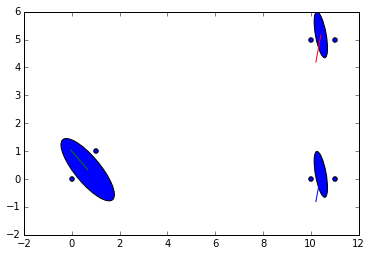

Passed test_em_gmm test


In [136]:
from matplotlib.patches import Ellipse 

def plot_gmm_solution(X, mu, sigma):
    
    fig = plt.figure(0)
    ax = fig.add_subplot(111)
    for i in range(len(sigma)):
        D, U = np.linalg.eigh(sigma[i])
        #print(sigma)
        print(np.linalg.eigh(sigma[i]))
        #print(U)
        
        ax.add_artist(Ellipse(xy=mu[i], width=D[1]*9, height=D[0]*9, angle=np.degrees(np.arccos(U[0][0]))))
        ax.plot([mu[i][0], mu[i][0]+U[0][0]],[mu[i][1], mu[i][1]+U[0][1]])
        #ax.plot([mu[i][0], mu[i][0]+U[1][0]],[mu[i][1], mu[i][1]+U[1][1]])
    
    ax.scatter(X.T[0], X.T[1])
    ax.scatter(mu.T[0], mu.T[1], marker="x", color="red")
    '''
    for i in range(len(sigma)):
        ax.gauss(X[0], X[1], sigma=sigma[i], mu=mu[i])
    '''
    
    plt.show()

test_em_gmm()

Assignment 7

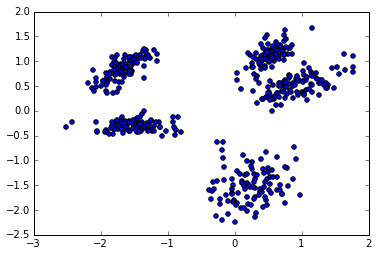

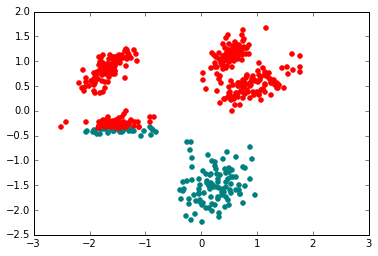

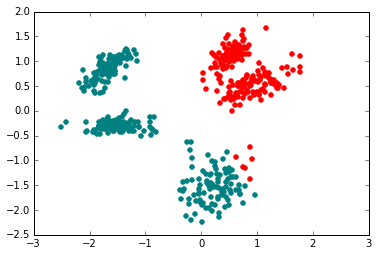

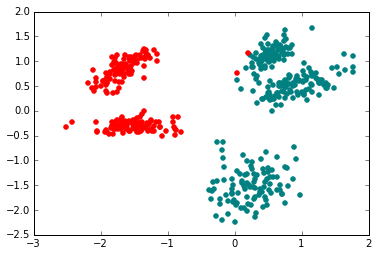

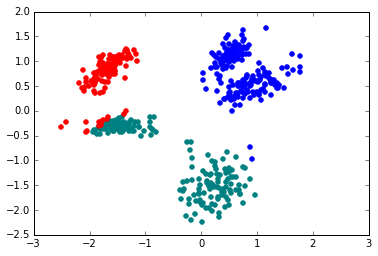

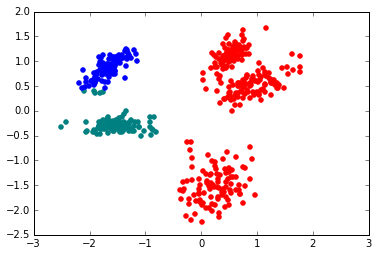

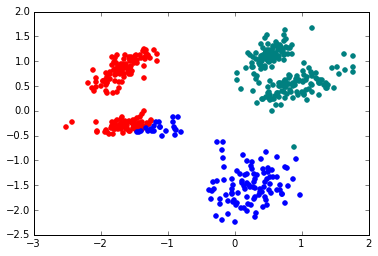

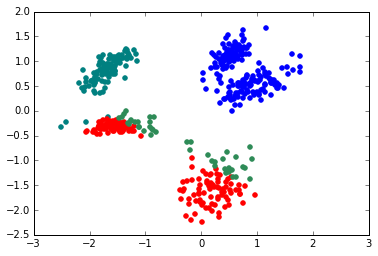

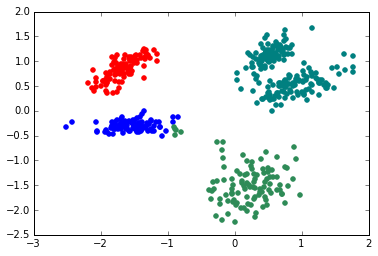

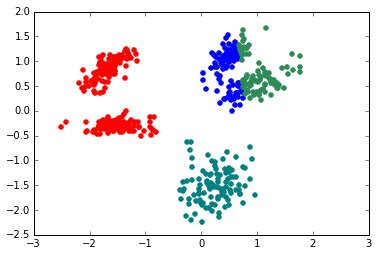

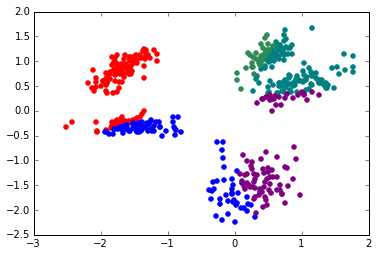

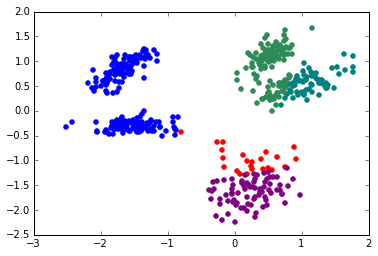

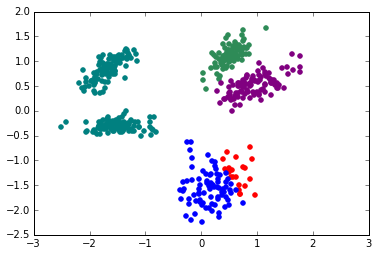

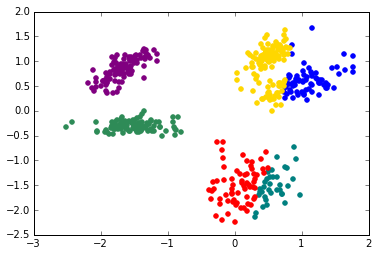

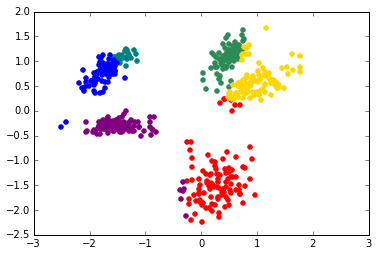

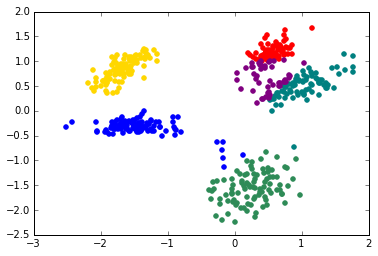

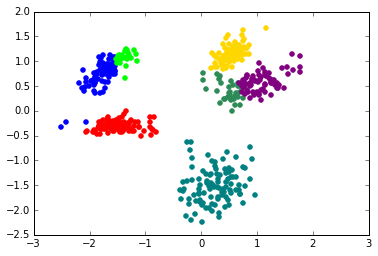

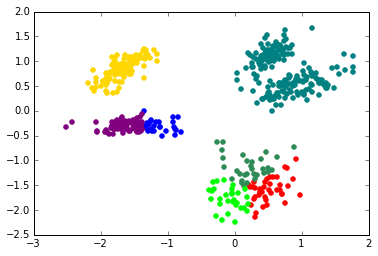

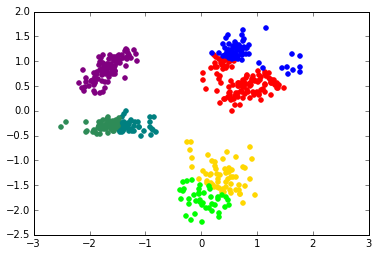

In [139]:
data = np.load("5_gaussians.npy").T
plt.scatter(data.T[0], data.T[1])
plt.show()

colors = ["teal", "red", "blue", "seagreen", "purple", "gold", "lime"]

for k in [2,3,4,5,6,7]:
    for h in range(3):
        µ, r, L = kmeans(data, k)
        #print(µ)
        #print(r.shape)
        #print(L)
        #pis, mus, sigmas, ll_new = em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-5)
        #print(pis)
        for i in range(k):
            plt.scatter(data[(r==i).reshape(500,)].T[0], data[(r==i).reshape(500,)].T[1], color=colors[i])
        plt.show()
    '''
    for i in range(k):
        plt.scatter(data[(r==i).reshape(500,)].T[0], data[(r==i).reshape(500,)].T[1], color=colors[i])
    plt.show()
    '''

Assignment 8

Assignment 9

Assignment 10